In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.arima import AutoARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA


## Loading Data

In [50]:
parking_data = pd.read_csv('parkingLot (1).csv')

In [51]:
parking_data.head()

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1


In [52]:
parking_data.isnull().sum()

vehicle_no    441
timestamp       0
camera_id       0
dtype: int64

## Data Analysis

>*NOTE* :
>We will be assuming that no car stays in the mall overnight

### Analysing Downtimes

Finding all the timestamps at which the cameras go off

In [53]:
downtime = parking_data[parking_data['vehicle_no'].isnull()]['timestamp'].unique()
downtime

array(['2024-09-14 09:00:00', '2024-09-14 09:20:00',
       '2024-09-21 09:00:00', '2024-09-21 09:20:00',
       '2024-09-28 09:00:00', '2024-09-28 09:20:00',
       '2024-10-05 09:00:00', '2024-10-05 09:20:00',
       '2024-10-12 09:00:00', '2024-10-12 09:20:00',
       '2024-10-19 09:00:00', '2024-10-19 09:20:00',
       '2024-10-26 09:00:00', '2024-10-26 09:20:00',
       '2024-11-02 09:00:00', '2024-11-02 09:20:00',
       '2024-11-09 09:00:00', '2024-11-09 09:20:00'], dtype=object)

In [54]:
downtime = pd.to_datetime(downtime) 
new_downtime = downtime[2:]
downtime[:-2] - new_downtime

TimedeltaIndex(['-7 days', '-7 days', '-7 days', '-7 days', '-7 days',
                '-7 days', '-7 days', '-7 days', '-7 days', '-7 days',
                '-7 days', '-7 days', '-7 days', '-7 days', '-7 days',
                '-7 days'],
               dtype='timedelta64[ns]', freq=None)

So we observe that the downtime is scheduled in a perfect interval of 7 days on Saturday mornings. 

Now let us check which camera goes off at 09:00 am on Saturday mornings

In [55]:
nine_am_downtime = downtime[downtime.time == pd.to_datetime('09:00:00').time()]
nine_am_downtime

DatetimeIndex(['2024-09-14 09:00:00', '2024-09-21 09:00:00',
               '2024-09-28 09:00:00', '2024-10-05 09:00:00',
               '2024-10-12 09:00:00', '2024-10-19 09:00:00',
               '2024-10-26 09:00:00', '2024-11-02 09:00:00',
               '2024-11-09 09:00:00'],
              dtype='datetime64[ns]', freq=None)

In [56]:
filter = parking_data['timestamp'].isin(nine_am_downtime)
parking_data[filter]['camera_id'].nunique()

0

So this means that both the cameras go off at 9 am.

In [57]:
nine_twent_am_downtime = downtime[downtime.time == pd.to_datetime('09:20:00').time()]
nine_twent_am_downtime

DatetimeIndex(['2024-09-14 09:20:00', '2024-09-21 09:20:00',
               '2024-09-28 09:20:00', '2024-10-05 09:20:00',
               '2024-10-12 09:20:00', '2024-10-19 09:20:00',
               '2024-10-26 09:20:00', '2024-11-02 09:20:00',
               '2024-11-09 09:20:00'],
              dtype='datetime64[ns]', freq=None)

In [58]:
filter = parking_data['timestamp'].isin(nine_twent_am_downtime)
parking_data[filter]['camera_id'].nunique()

0

In [59]:
parking_data.shape

(106694, 3)

> 
> So we conclude that both the cameras are under maintainance on every Saturday morning at timestamps 09:00:00 and 09:20:00.


### Analysing the Entry And Exit of Cars
We will check whether each car which enters on one day exits on the same day. If this is the case, the can simply take the difference between the time of leaving of all the cars and time of entering of cars on a particular day and divide it by the number of cars entering and exiting so as to get the average time spent by a car in the parking lot.

In [60]:
parking_data

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


We will consider the data of camera 2 uploaded at 00:00:00 as data of previous day, this is because this data included the cars which left the parking lot from 11:40 pm to 12:00 am; and therefore should be counted in previous day. However, we will include data of cars entering the parking lot between 11:40 pm to 12:00 am in calculations for average time slot of the next day since they will be leaving the parking lot on the following day.

Below is the code for these manipulations.

In [61]:
# Ensure 'timestamp' is in datetime format
parking_data['timestamp'] = pd.to_datetime(parking_data['timestamp'])

# Create a time object for midnight
midnight = pd.to_datetime('00:00:00').time()
mask = (parking_data['timestamp'].dt.time == midnight) & (parking_data['camera_id'] == 2)
# Subtract 1 second from timestamps that are exactly midnight
parking_data.loc[mask, 'timestamp'] -= pd.to_timedelta(1, unit='s')


In [62]:
parking_data['count'] = 1
parking_data['day'] = parking_data['timestamp'].dt.date

Let us check if the number of cars entering the parking lot on a given day are equal to the number of cars exiting the parking lot on the same day. If they are not equal, it means that there is a data discrepancy and we need to investigate further.

Text(0.5, 1.0, 'Difference in counts between camera 1 and 2')

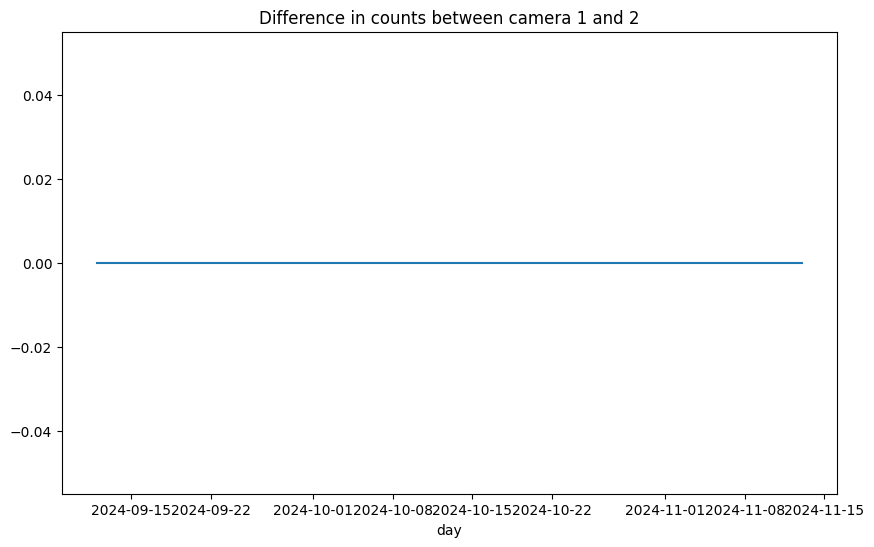

In [63]:
df = parking_data.groupby(['day', 'camera_id'])['count'].sum().unstack()
df['diff'] = df[1] - df[2]
plt.figure(figsize=(10, 6))
df['diff'].plot()
plt.title('Difference in counts between camera 1 and 2')

In [64]:
df

camera_id,1,2,diff
day,,,
2024-09-12,886,886,0
2024-09-13,809,809,0
2024-09-14,925,925,0
2024-09-15,1073,1073,0
2024-09-16,843,843,0
...,...,...,...
2024-11-09,906,906,0
2024-11-10,944,944,0
2024-11-11,828,828,0


In [65]:
# Crete a series which has the number of cars in the parking lot on each day
num_cars = df[1]
num_cars

day
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     906
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Name: 1, Length: 63, dtype: int64

In [66]:
# Delete all the unncesaary dataframes created
del mask
del midnight
del nine_twent_am_downtime
del nine_am_downtime
del downtime
del new_downtime

## Data Preparation For Time Series Modelling

In [67]:
# For each day, calculate the number
parking_data.drop(columns=['count'], inplace=True)
parking_data

,vehicle_no,timestamp,camera_id,day
0,MHUN7063,2024-09-12 05:00:00,1,2024-09-12
1,MHYN4677,2024-09-12 05:00:00,1,2024-09-12
2,MHEL6595,2024-09-12 05:00:00,1,2024-09-12
3,MHNQ2590,2024-09-12 05:00:00,1,2024-09-12
4,MHHA0518,2024-09-12 05:00:00,1,2024-09-12
...,...,...,...,...
106689,MHCN7114,2024-11-13 23:59:59,2,2024-11-13
106690,MHVY8418,2024-11-13 23:59:59,2,2024-11-13
106691,MHSR8102,2024-11-13 23:59:59,2,2024-11-13
106692,MHQG5264,2024-11-13 23:59:59,2,2024-11-13


In [68]:
parking_data['timestamp'] = pd.to_datetime(parking_data['timestamp'])

In [69]:
# Separate DataFrames for camera_id 1 and camera_id 2
parking_data_cam1 = parking_data[parking_data['camera_id'] == 1].copy()
parking_data_cam2 = parking_data[parking_data['camera_id'] == 2].copy()

# Convert the timestamps to total minutes from midnight
# Round of seconds to the nearest minute
parking_data_cam1['minutes'] = parking_data_cam1['timestamp'].dt.hour * 60 + parking_data_cam1['timestamp'].dt.minute + np.ceil(parking_data_cam1['timestamp'].dt.second/60)
parking_data_cam2['minutes'] = parking_data_cam2['timestamp'].dt.hour * 60 + parking_data_cam2['timestamp'].dt.minute + np.ceil(parking_data_cam2['timestamp'].dt.second/60)

# Sum of times (in minutes) for each day for camera_id 1 and camera_id 2
sum_cam1 = parking_data_cam1.groupby('day')['minutes'].sum().reset_index(name='sum_minutes_cam1')
sum_cam2 = parking_data_cam2.groupby('day')['minutes'].sum().reset_index(name='sum_minutes_cam2')

# Merge the sums on 'day'
merged_parking_data = pd.merge(sum_cam1, sum_cam2, on='day')

# Calculate the difference (in minutes) between the sums
merged_parking_data['time_diff_minutes'] = merged_parking_data['sum_minutes_cam2'] - merged_parking_data['sum_minutes_cam1']

print(merged_parking_data)


           day  sum_minutes_cam1  sum_minutes_cam2  time_diff_minutes
0   2024-09-12          651560.0          875520.0           223960.0
1   2024-09-13          545140.0          859080.0           313940.0
2   2024-09-14          575280.0         1032200.0           456920.0
3   2024-09-15          643520.0         1220080.0           576560.0
4   2024-09-16          527460.0          952440.0           424980.0
..         ...               ...               ...                ...
58  2024-11-09          639540.0          919820.0           280280.0
59  2024-11-10          680800.0          950900.0           270100.0
60  2024-11-11          606560.0          838900.0           232340.0
61  2024-11-12          591100.0          824760.0           233660.0
62  2024-11-13          550560.0          794480.0           243920.0

[63 rows x 4 columns]


In [70]:
merged_parking_data.set_index('day', inplace=True)
average_time_spent = merged_parking_data['time_diff_minutes'] / num_cars

<Axes: title={'center': 'Average Time Spent in Parking Lot'}, xlabel='day'>

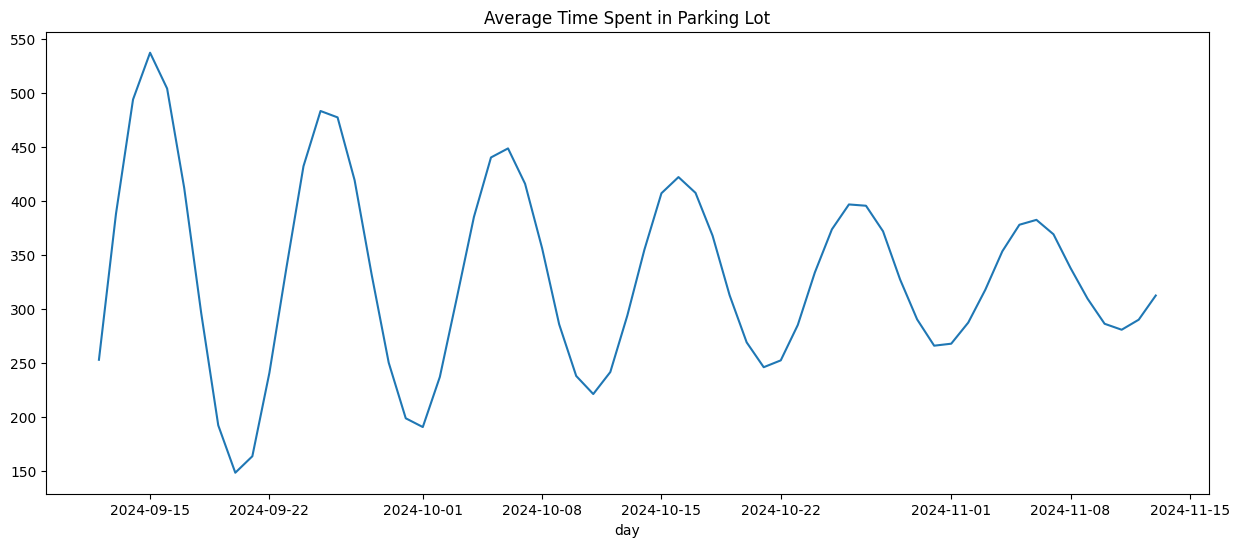

In [71]:
average_time_spent.plot(figsize=(15, 6), title='Average Time Spent in Parking Lot')

In [72]:
del sum_cam1
del sum_cam2
del parking_data_cam1
del parking_data_cam2
del merged_parking_data
del parking_data
del num_cars

In [73]:
average_time_spent

day
2024-09-12    252.776524
2024-09-13    388.059333
2024-09-14    493.967568
2024-09-15    537.334576
2024-09-16    504.128114
                 ...    
2024-11-09    309.359823
2024-11-10    286.122881
2024-11-11    280.603865
2024-11-12    289.900744
2024-11-13    312.317542
Length: 63, dtype: float64

### Time Series Analysis

In [74]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y, autolag='AIC')[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

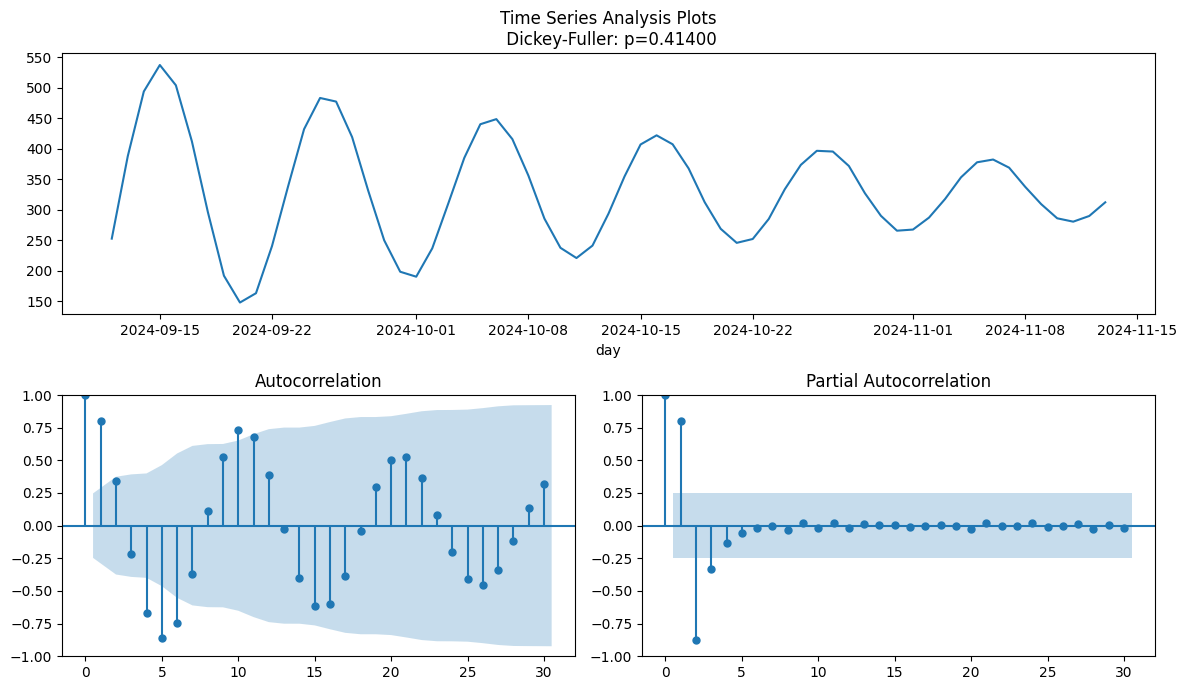

In [75]:
tsplot(average_time_spent, lags=30)

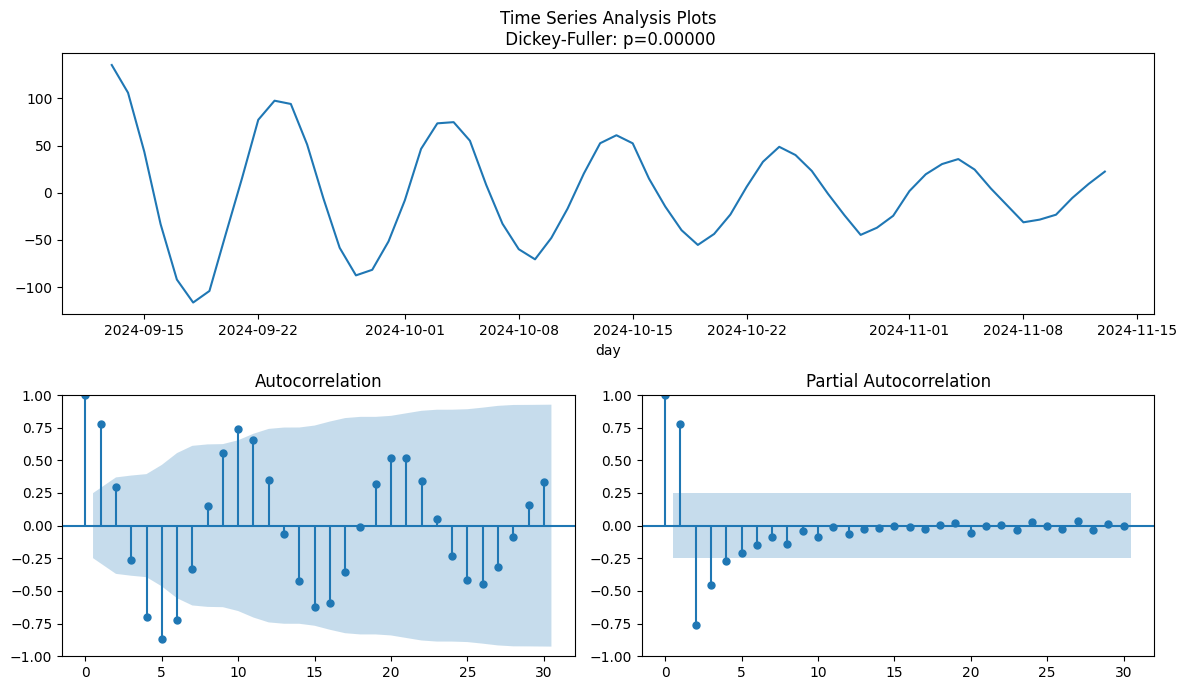

In [76]:
# Differencing
data_diff = (average_time_spent - average_time_spent.shift(1)).dropna()
tsplot(data_diff, lags=30)


In [77]:
def check_seasonality(time_series, period=None, model='additive', plot=True):

    decomposition = seasonal_decompose(time_series, model=model, period=period)
    
    if plot:
        # plt.figure(figsize=(40, 8))
        decomposition.plot()
        plt.show()
    
    return {
        'Trend': decomposition.trend,
        'Seasonal': decomposition.seasonal,
        'Residual': decomposition.resid
    }

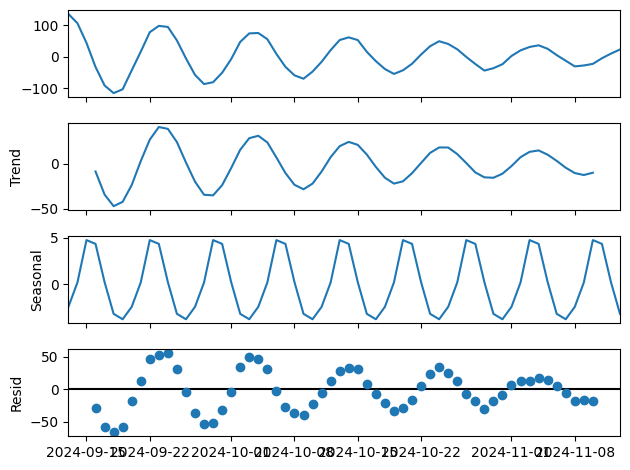

In [78]:
_ = check_seasonality(data_diff, period=7, plot=True)

## Time-Series Modelling

In [79]:
def mean_absolute_percentage_error(y_true, y_pred):
	"""
	Calculate Mean Absolute Percentage Error (MAPE)
	
	Parameters:
	y_true (array-like): Actual values
	y_pred (array-like): Predicted values
	
	Returns:
	float: MAPE value
	"""
	y_true = np.array(y_true)
	y_pred = np.array(y_pred)
	
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [80]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate Mean Absolute Scaled Error (MASE)
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    
    Returns:
    float: MASE value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    n = len(y_true)
    mae = np.mean(np.abs(y_true - y_pred))
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    
    return mae / naive_mae

In [81]:
df = pd.DataFrame(average_time_spent)
df.index = pd.to_datetime(df.index)
df.rename(columns={0: 'value'}, inplace=True)


Test-Train Split

In [82]:
_test, _train = df.iloc[-7:], df.iloc[:-7]

In [83]:
forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -165.106
Date:                Mon, 28 Oct 2024   AIC                            344.213
Time:                        18:34:57   BIC                            358.390
Sample:                    09-12-2024   HQIC                           349.709
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    115.6845      2.952     39.190      0.000     109.899     121.470
ar.L1          1.6437      0.008    198.757      0.000       1.628       1.660
ar.L2         -0.9976      0.002   -478.882      0.000      -1.002      -0.993
ma.L1         -0.1400      0.150     -0.931      0.352      -0.435       0.155
ma.L2          0.4443      0.121      3.670      0.000       0.207       0.682
ma.L3          0.3056      0.195      1.570      0.116      -0.076       0.687
sigma2        16.1322      3.504      4.604      0.000       9.264      23.000
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.44   Prob(JB):                         0.66
Heteroskedasticity (H):               0.45   Skew:                            -0.22
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> The order of the parameters are (2, 0, 3) and the seasonal order parameters are (2, 1, 0, 7). <br>

For the auto-regressive term, the auto regressive term (p) can be inferredd from the PACF plot. Although the PACF plot indicates a significant spike in first 4 lags, the AutoARIMA gives p to be 2 after grid optimization. <br> 

The moving average term is for smoothening, and is kept ot be 3 here by AutoARIMA.

There is a very strong seasonality in the data. The model has a seasonal differencing term of 1, which differencing indicates the data has a seasonal pattern that repeats every s periods (7 in this case), and the data was differenced once to remove this seasonality. <br>

The seasonal auto-retregressive term is 2, indicating that the values are influenced by the 2 previous seasonal values. Apparently, no seasonal smoothening is needed, and therefore the seasonal moving average term is 0.

We will be using the model parameters (3, 0, 1) and (2, 1, 0, 7) for the SARIMAX which we will use to generate forecasts for future unseen data, which are more intutive than the one given by AutoARIMA.


In [84]:
import warnings
warnings.filterwarnings('ignore')
custom_model = SARIMAX(_train, order=(3,0,1), seasonal_order=(2,0,1,7))
custom_forecaster = custom_model.fit()
custom_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                   56
Model:             SARIMAX(3, 0, 1)x(2, 0, 1, 7)   Log Likelihood                -175.810
Date:                           Mon, 28 Oct 2024   AIC                            367.620
Time:                                   18:34:59   BIC                            383.823
Sample:                               09-12-2024   HQIC                           373.901
                                    - 11-06-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6395      0.011    251.292      0.000       2.619       2.660
ar.L2         -2.6386      0.015   -174.967      0.000      -2.668      -2.609
ar.L3          0.9990      0.008    117.827      0.000       0.982       1.016
ma.L1         -0.9691      0.464     -2.089      0.037      -1.878      -0.060
ar.S.L7        0.8905      2.360      0.377      0.706      -3.735       5.516
ar.S.L14       0.1059      0.217      0.489      0.625      -0.319       0.531
ma.S.L7       -0.9854      5.166     -0.191      0.849     -11.111       9.141
sigma2        20.3419     55.289      0.368      0.713     -88.022     128.706
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.31   Prob(JB):                         0.68
Heteroskedasticity (H):               0.40   Skew:                            -0.27
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The custom forecaster has slighly lower log-likelihood than that of the one given by Seasonal ARIMA.

In [85]:
custom_forecast = custom_forecaster.get_forecast(steps=7)
# custom_forecast.summary_frame()
custom_forecast_mean = custom_forecast.predicted_mean
custom_forecast_ci = custom_forecast.conf_int()

In [86]:
fh = np.arange(1, len(_test) + 1)
forecast = forecaster.predict(fh)

In [87]:
forecast

,value
2024-11-07,369.101214
2024-11-08,341.355015
2024-11-09,308.370918
2024-11-10,282.026802
2024-11-11,271.629092
2024-11-12,280.818708
2024-11-13,306.296336


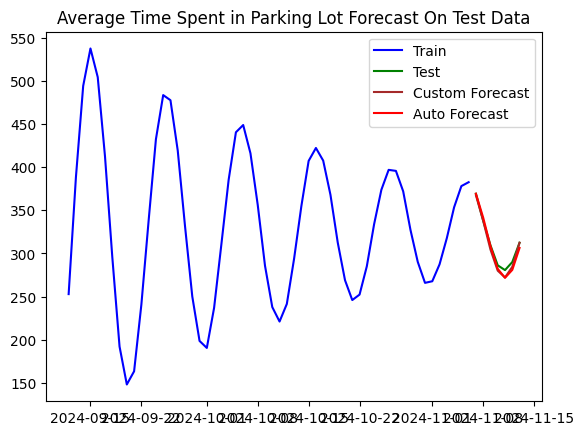

In [88]:
plt.title('Average Time Spent in Parking Lot Forecast On Test Data') 
plt.plot(_train, label='Train', color='b')
plt.plot(_test, label='Test', color='g')
plt.plot(custom_forecast_mean, label='Custom Forecast', color='brown')
plt.plot(forecast, label='Auto Forecast', color='r')
plt.legend()
plt.show()



In [89]:
custom_forecast_mean = pd.DataFrame(custom_forecast_mean)
custom_forecast_mean

,predicted_mean
2024-11-07,367.420641
2024-11-08,337.769741
2024-11-09,304.432184
2024-11-10,279.924667
2024-11-11,272.082472
2024-11-12,284.335169
2024-11-13,312.283659


In [90]:
mase = mean_absolute_scaled_error(_test, forecast)
mape = mean_absolute_percentage_error(_test, forecast)
mase, mape
print(f"For the AUTO_ARIMA FORECAST, The Mean Absolute Scaled Error (MASE) is {mase} and the Mean Absolute Percentage error is {mape}" )
new_mase = mean_absolute_scaled_error(_test, custom_forecast_mean)
new_mape = mean_absolute_percentage_error(_test, custom_forecast_mean)
print(f"For the CUSTOM SARIMAX FORECAST, The Mean Absolute Scaled Error (MASE) is {new_mase} and the Mean Absolute Percentage error is {new_mape}")

For the AUTO_ARIMA FORECAST, The Mean Absolute Scaled Error (MASE) is 0.23360665940014136 and the Mean Absolute Percentage error is 1.581811292374805
For the CUSTOM SARIMAX FORECAST, The Mean Absolute Scaled Error (MASE) is 0.19200728366749065 and the Mean Absolute Percentage error is 1.3115706406319252


So our custom forecaster has slighly better metrics than the one given by AutoARIMA.

## Generating Forecasts

In [91]:
warnings.filterwarnings('ignore')
order = (3,0,1)
seasonal_order = (2,1,0,7)
model = SARIMAX(df, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(_test))

In [92]:
forecast_ci = model_fit.get_forecast(steps=len(_test)).conf_int()

In [93]:
forecast_ci

,lower value,upper value
2024-11-14,332.801660,348.714548
2024-11-15,346.514729,371.158736
2024-11-16,351.734349,382.689328
2024-11-17,345.274225,377.798088
2024-11-18,329.527273,362.078043
2024-11-19,301.754345,336.676759
2024-11-20,281.268843,321.094894


In [94]:
forecast

2024-11-14    340.758104
2024-11-15    358.836733
2024-11-16    367.211839
2024-11-17    361.536156
2024-11-18    345.802658
2024-11-19    319.215552
2024-11-20    301.181868
Freq: D, Name: predicted_mean, dtype: float64

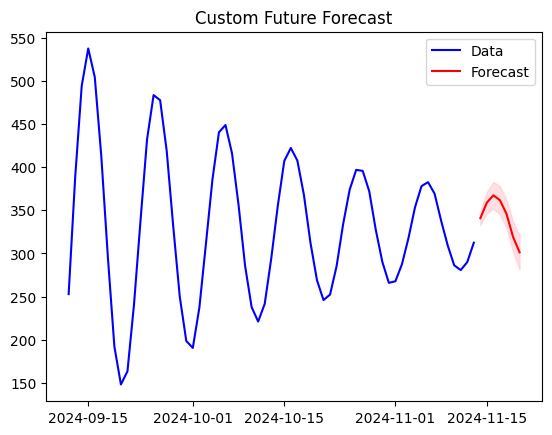

In [95]:
plt.title('Custom Future Forecast')
plt.plot(df, label='Data', color='b')
plt.plot(forecast, label='Forecast', color='r')
plt.fill_between(forecast.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend()
plt.show()

As we can see, the confidence interval range is very narrow which means that the Model is performing well.